# P1 - TSA - Acceso a Internet en Colombia

Elaborado por GRUPO 1:
- Juanita Piraban Barbosa - 201216313
- Lorena Morales Rodríguez - 202027957
- Alejandro Barinas Guio - 201628859
- Jaime Humberto Trujillo Perea - 201920366
- Alexander Zapata Galindo - 201425426

In [3]:
# Importar Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import sys
import plotly as pt
import plotly.express as px
import warnings

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from matplotlib import pyplot
from pandas import DatetimeIndex
from pandas import Series

%matplotlib inline
sns.set()  

ModuleNotFoundError: No module named 'prophet'

In [5]:
# Leer el archivo 'datos.csv'
df = pd.read_excel("DataSet/P1_Serie_Acceso_Internet.xlsx",index_col=0)

# Parte A. Contexto y relevancia del problema

### $\color{red}{\text{TODOS}}$ 

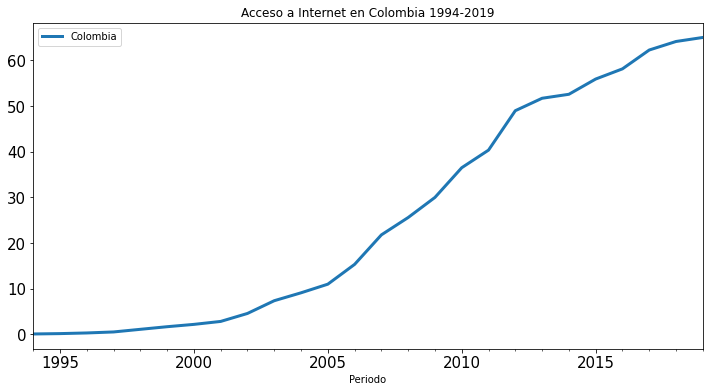

In [6]:
df.plot(figsize=(12, 6),linewidth=3, fontsize=15, title='Acceso a Internet en Colombia 1994-2019');

# Parte B. Análisis de los principales componentes de la serie

### $\color{red}{\text{JAIME}}$ 

# Estacionariedad

In [7]:
#DF Test
result = adfuller(df['Colombia'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 2.702899
p-value: 0.999087
Critical Values:
	1%: -3.924
	5%: -3.068
	10%: -2.674


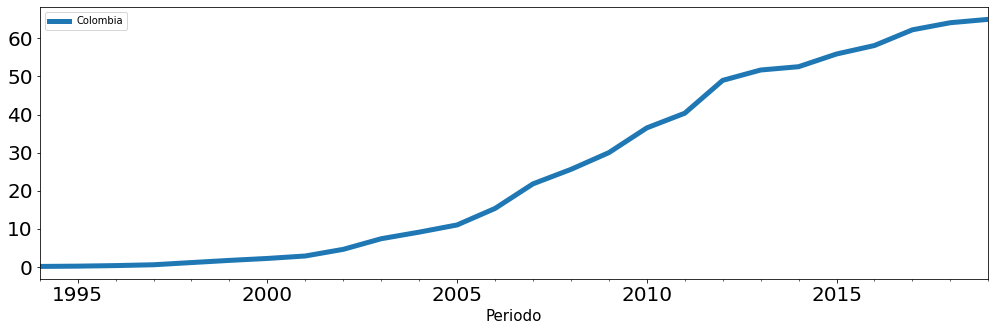

In [9]:
df.rolling(1).mean().plot(figsize=(17,5), linewidth=5, fontsize=20)
plt.xlabel('Periodo', fontsize=15);

En este caso, el test no rechaza la Ho de que la serie no es estacionaria.

# Tendencia

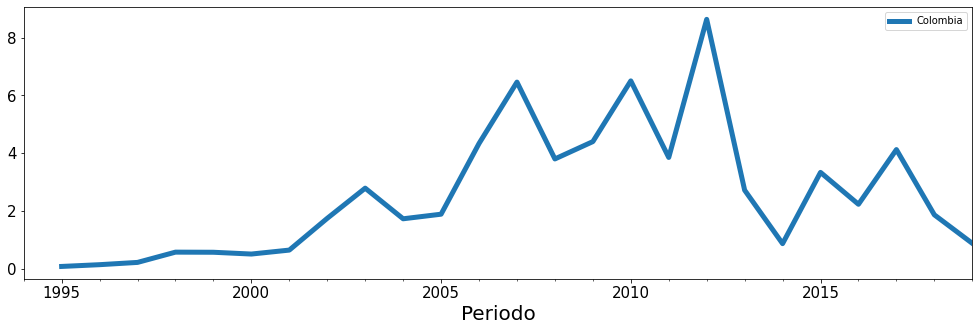

In [8]:
df.diff().plot(figsize=(17,5), linewidth=5, fontsize=15)
plt.xlabel('Periodo', fontsize=20);

In [ ]:
result = adfuller(df['Periodo'].diff().iloc [ 1 :]) 
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

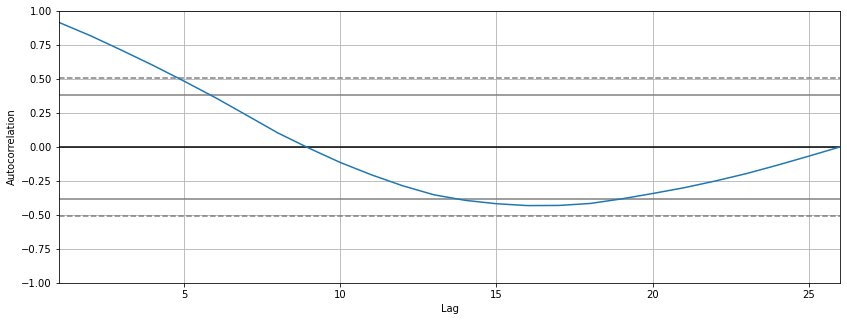

In [10]:
plt.figure(figsize=(14,5))
pd.plotting.autocorrelation_plot(df);

# Estacionalidad

# Parte C. Modelos y Proyecciones

In [253]:
warnings.filterwarnings('ignore')

## C.1. Modelos ARIMA

### $\color{red}{\text{JUANITA-ALEX}}$ 

## 1. Modelos

Se transforma la serie en logaritmo y se diferencia una vez:

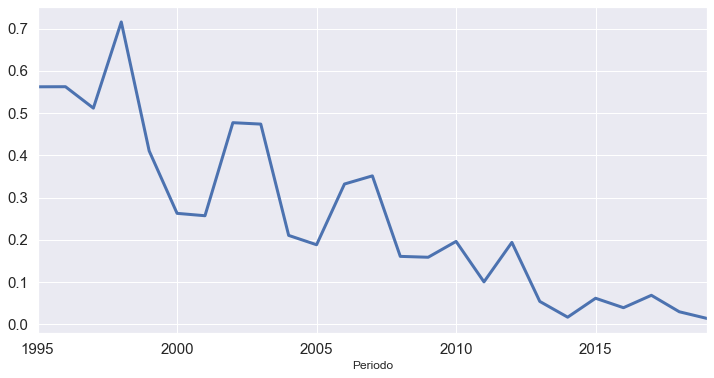

In [254]:
df['log_Colombia'] = np.log(df['Colombia'])
df_log=df.iloc[:,1:3]
df_log= df.log_Colombia.diff()
df_log=df_log.dropna()
df_log.plot(figsize=(12, 6),linewidth=3, fontsize=15);

In [255]:
result = adfuller(df_log)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.834710
p-value: 0.808713
Critical Values:
	1%: -3.889
	5%: -3.054
	10%: -2.667


La serie sigue siendo no estacionaria. Luego se diferencia una vez más.

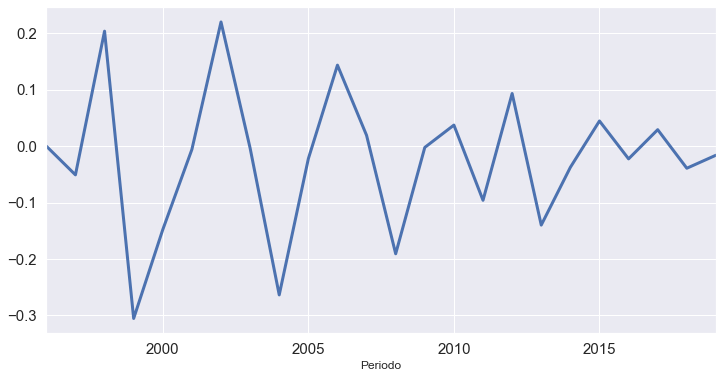

In [256]:
df_log_1= df_log.diff()
df_log_1=df_log_1.dropna()
df_log_1.plot(figsize=(12, 6),linewidth=3, fontsize=15);

In [257]:
result = adfuller(df_log_1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.201151
p-value: 0.673100
Critical Values:
	1%: -4.012
	5%: -3.104
	10%: -2.691


La serie sigue siendo no estacionaria, a pesar de las dos diferenciaciones anteriores.

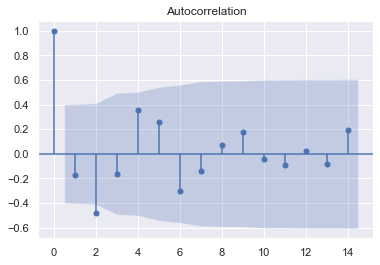

In [258]:
# Función de Autocorrelación (opción 1)
plot_acf(df_log_1);

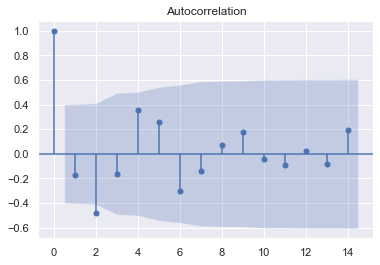

In [259]:
# Función de Autocorrelación (opción 2)
serie = np.log(df['Colombia']).diff().diff().dropna()
plot_acf(serie);

In [ ]:
#Función de Autocorrelación Parcial (opción 1)
#plot_pacf(df_log_1);

In [ ]:
#Función de Autocorrelación Parcial (opción 2)
#plot_pacf(serie,nlags=10);

In [261]:
#Bases de train y test
X = df['Colombia'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
future = [x for x in test]

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   15
Model:                 ARIMA(1, 2, 0)   Log Likelihood                   7.481
Method:                       css-mle   S.D. of innovations              0.147
Date:                Mon, 12 Jul 2021   AIC                             -8.961
Time:                        22:50:42   BIC                             -6.837
Sample:                             2   HQIC                            -8.984
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0250      0.035     -0.722      0.470      -0.093       0.043
ar.L1.D2.y    -0.1050      0.250     -0.420      0.675      -0.595       0.385
                                    Roots           

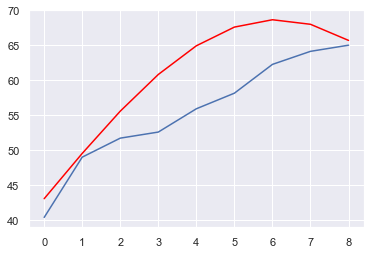

In [262]:
# fit modelo 1 - ARIMA(1,2,0)
model1 = ARIMA(np.log(history), order=(1,2,0))
model1_fit = model1.fit(disp=0)
print(model1_fit.summary())

output = model1_fit.forecast(steps=len(test))[0]
yhat = output
predictions = np.exp(yhat)
real_values = future

print(pd.DataFrame({'predict':predictions, 'real':real_values}))

plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

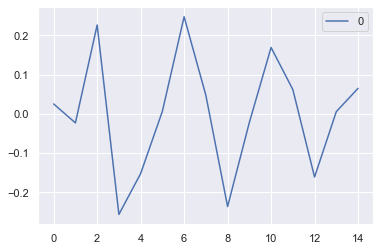

In [263]:
# plot residual errors
residuals = pd.DataFrame(model1_fit.resid)
residuals.plot()
plt.show()

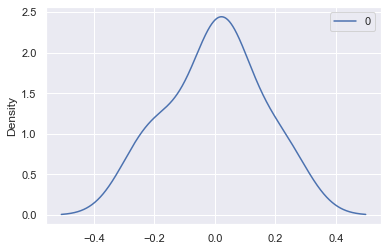

               0
count  15.000000
mean    0.000176
std     0.152057
min    -0.256332
25%    -0.087722
50%     0.006395
75%     0.063439
max     0.247338


In [264]:
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [265]:
# MSE
mse1 = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % mse1)

Test MSE: 35.277


In [ ]:
# fit modelo 2 - ARIMA(2,2,0)
#model2 = ARIMA(np.log(history), order=(2,2,0))
#model2_fit = model1.fit(disp=0)
#print(model2_fit.summary())

#output = model2_fit.forecast(steps=len(test))[0]
#yhat = output
#predictions = np.exp(yhat)
#real_values = future

#print(pd.DataFrame({'predict':predictions, 'real':real_values}))

#plt.plot(test)
#plt.plot(predictions, color='red')
#plt.show()

In [ ]:
# plot residual errors
#residuals = pd.DataFrame(model2_fit.resid)
#residuals.plot()
#plt.show()

In [ ]:
#residuals.plot(kind='kde')
#plt.show()
#print(residuals.describe())

In [ ]:
# MSE
#mse2 = mean_squared_error(test, predictions)
#print('Test MSE: %.3f' % mse2)

In [ ]:
# Comparación de MSE
#from tabulate import tabulate
#table = [['Modelo', 'MSE'],['ARIMA (1,2,0)', mse1],['ARIMA (2,2,0)', mse2]]
#print(tabulate(table))

## 2. Proyección a 5 años (fuera de la muestra)

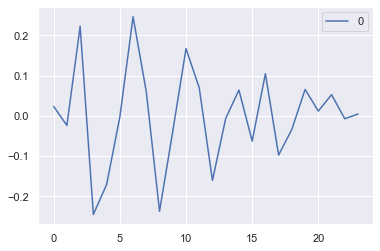

In [267]:
#Modelo final con todos los datos
model_def = ARIMA(np.log(X), order=(1,2,0))
model_def_fit = model_def.fit(disp=0)

# plot residual errors
residuals = pd.DataFrame(model_def_fit.resid)
residuals.plot()
plt.show()

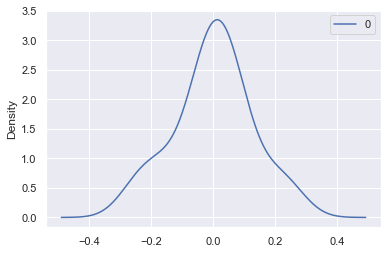

               0
count  24.000000
mean    0.000159
std     0.124666
min    -0.245116
25%    -0.044569
50%     0.000727
75%     0.064362
max     0.246230


In [269]:
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

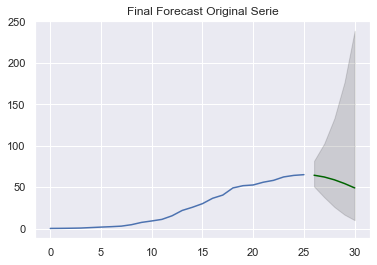

In [268]:
#Proyección por fuera de la muestra
n_periods = 5
fc, se, conf = model_def_fit.forecast(steps=n_periods)

#Extraer series
index_of_fc = np.arange(len(X), len(X)+n_periods)
fc_serie = np.exp(pd.Series(fc, index=index_of_fc))
lower_serie = np.exp(pd.Series(conf[:, 0], index=index_of_fc))
upper_serie = np.exp(pd.Series(conf[:, 1], index=index_of_fc))

# Gráfico
plt.plot(X)
plt.plot(fc_serie, color='darkgreen')
plt.fill_between(lower_serie.index,lower_serie, upper_serie, 
                 color='k', alpha=.15)
plt.title("Final Forecast Original Serie")
plt.show()

## C.2. Modelo Prophet

### $\color{red}{\text{LORE-ALEJO}}$ 

## 1. Modelo

## 2. Proyección a 5 años (fuera de la muestra)

# Conclusiones

### $\color{red}{\text{TODOS}}$ 